# Surface profile

In this notebook, we process the surface profile data obtained from the confocal distance measuring tool. NOTE: this data is not thickness.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

## 1 Load data

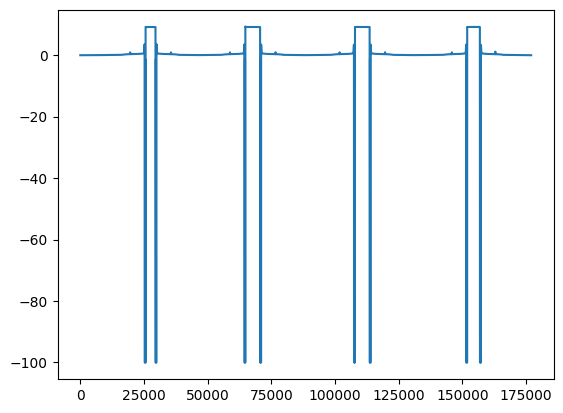

In [462]:
folder = r"E:\WPM\04182024"
filename = "r_v-3"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.plot(raw)

## 2 Trim the profile

### 2.1 Trim the last part

In the current method, I manually move the tool horizontally to achieve a scan. At the end of the scan, there is a delay between I stop moving the tool and I stop recording the signal. As a result, there is always a plateau at the end of each scan data, which should be manually removed before further processing.

(0.0, 3.0)

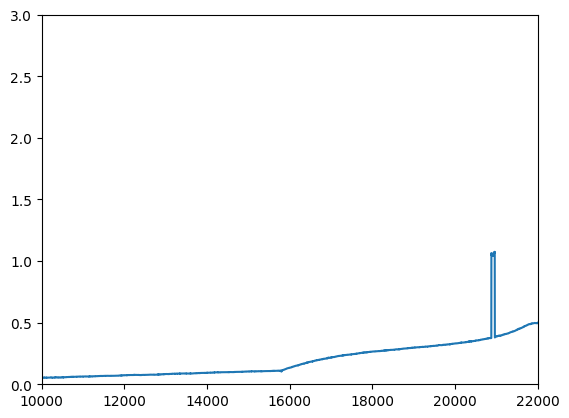

In [185]:
plt.plot(raw)
plt.xlim([10000, 22000])
plt.ylim([0, 3])

From the above view we know that the plateau starts at around 112,500. So we slice the raw data up to 112,500.

In [186]:
raw_slice = raw[0:10600]

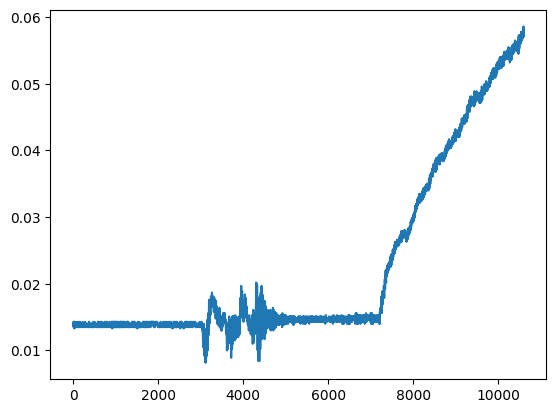

In [187]:
fig, ax = plt.subplots()
ax.plot(raw_slice)

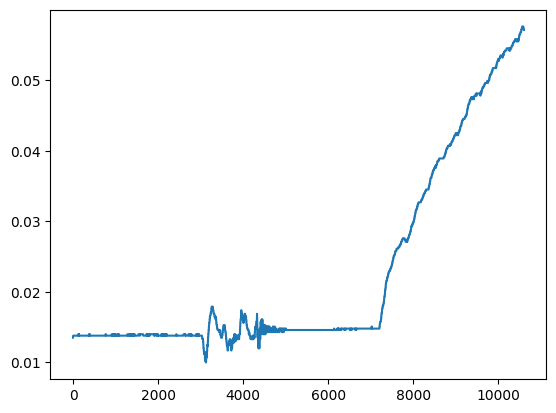

In [188]:
# smooth with median (optional)
raw_slice_smooth = medfilt(raw_slice, (51, 1))
plt.plot(raw_slice_smooth)

In [189]:
raw_slice = raw_slice_smooth

### 2.2 Cut out all the profiles

I sometimes put multiple scans of profiles in one .csv file. In this case, we need to cut them out as separate measurement. In this section, we implement tools to do this extraction.

In [190]:
raw.head()

,0.0138
0,0.0140
1,0.0140
2,0.0138
3,0.0140
4,0.0138


In [463]:
ind = raw.index[np.squeeze(np.sign(raw - 0.3).diff().ne(0).values)]

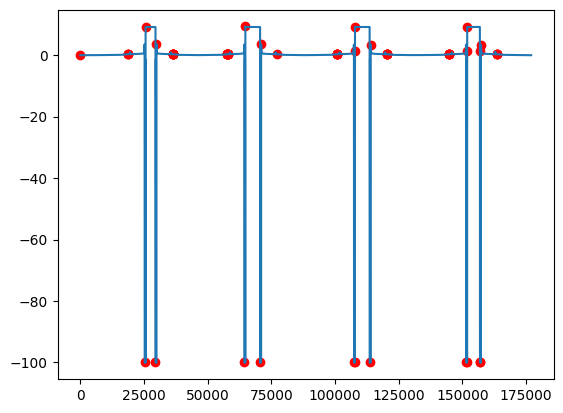

In [464]:
plt.plot(raw)
plt.scatter(ind, raw.loc[ind], color="red")

In [465]:
# get those with raw.loc[ind] > 0 and raw.loc[ind] < 1
ind01 = ind[np.squeeze(np.array((raw.loc[ind] > 0.25) & (raw.loc[ind] < .35)))]

In [466]:
ind01

Index([ 18584,  18585,  18590,  36378,  36380,  36392,  36394,  36398,  36401,
        36404,  57781,  57782,  57796,  57797,  57798,  57800,  57801,  57807,
        57808,  57809,  57815,  77430, 100846, 100847, 100858, 100863, 100864,
       120410, 120414, 120415, 120419, 120425, 144920, 144929, 144930, 144937,
       144938, 163683, 163684, 163688],
      dtype='int64')

(0.25, 0.35)

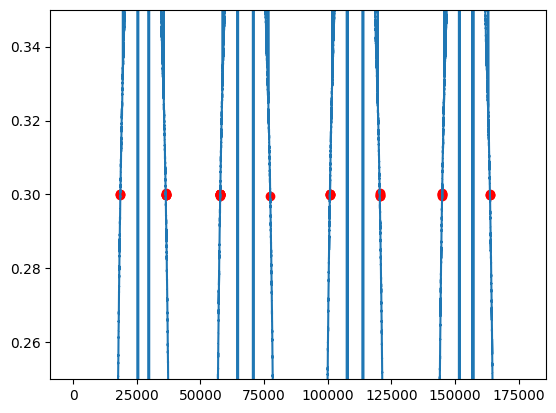

In [467]:
plt.plot(raw)
plt.scatter(ind01, raw.loc[ind01], color="red")
plt.ylim([.25, .35])

In [468]:
# better approache is to construct a table of start and direction in time order
start = [18584, 36404,  57781, 77430, 100846, 120425, 144938, 163688]
direction = ["b", "f", "b", "f", "b", "f", "b", "f", "b", "f"]

In [469]:
profiles = []
for s, d in zip(start, direction):
    if d == "f":
        profile = np.squeeze(raw.values)[s: s+10000]
    else:
        profile = np.flip(np.squeeze(raw.values)[s-10000: s])
    profiles.append(profile)

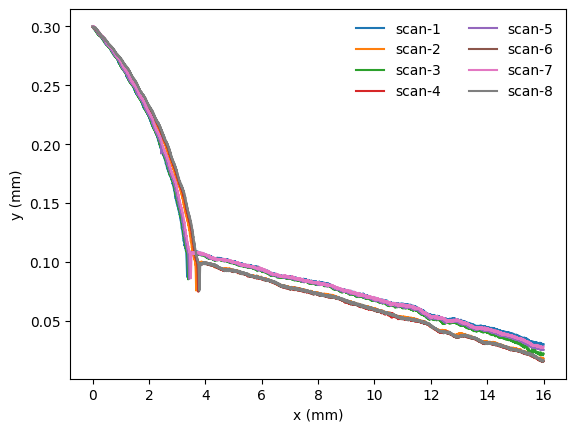

In [470]:
x = np.arange(10000) / 1000 * 1.6
count = 0
for profile in profiles:
    count += 1
    plt.plot(x, profile, label="scan-{:d}".format(count))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.legend(frameon=False, ncol=2)

In [471]:
stack = np.stack(profiles, axis=1)

In [472]:
df = pd.DataFrame(data=stack, columns=["scan-{:d}".format(i) for i in range(1, 9)])
df["x"] = x
df.set_index("x", inplace=True)

In [473]:
df

,scan-1,scan-2,scan-3,scan-4,scan-5,scan-6,scan-7,scan-8
x,,,,,,,,
0.0000,0.2998,0.2998,0.2998,0.2996,0.2998,0.2996,0.2998,0.2998
0.0016,0.2998,0.2996,0.2996,0.2998,0.2996,0.2996,0.3003,0.2998
0.0032,0.2996,0.2998,0.2993,0.2993,0.2996,0.2993,0.3001,0.2996
0.0048,0.2996,0.2996,0.2993,0.2993,0.2996,0.2996,0.3001,0.2998
0.0064,0.2996,0.2998,0.2993,0.2993,0.2996,0.2998,0.3001,0.2996
...,...,...,...,...,...,...,...,...
15.9920,0.0297,0.0180,0.0221,0.0162,0.0259,0.0159,0.0274,0.0169
15.9936,0.0297,0.0175,0.0223,0.0162,0.0259,0.0157,0.0277,0.0172
15.9952,0.0295,0.0177,0.0226,0.0164,0.0259,0.0154,0.0274,0.0172


In [474]:
df.to_csv(os.path.join(folder, "rubber_in_vinegar-3.csv"))

# Appendix

## A. With/without dye

We compare the surface profile measurement on front mirror for beet juice and pure water, to see the effect of dye on the measurement.

In [3]:
water = pd.read_csv(r"E:\WPM\04102024\water\beet-10.csv", usecols=[1], skiprows=12)

In [4]:
juice = pd.read_csv(r"E:\WPM\04102024\juice\beet-10.csv", usecols=[1], skiprows=12)

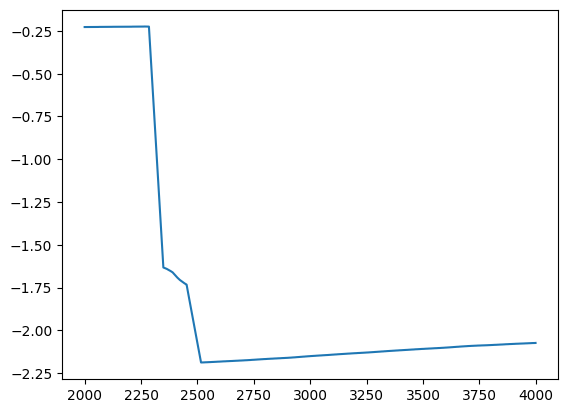

In [6]:
plt.plot(water[2000:4000])

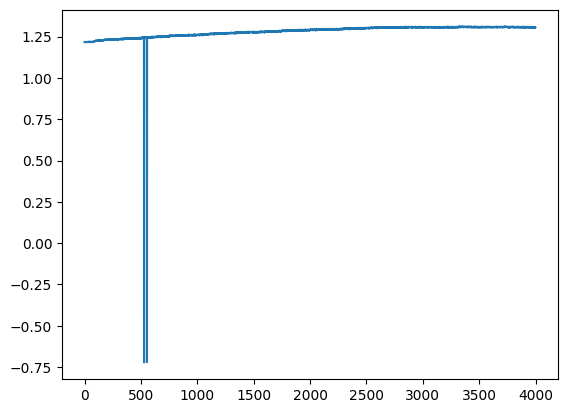

In [10]:
plt.plot(juice[:4000])